In [1]:
from __future__ import print_function, division

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
# from torch.optim import lr_scheduler
from torch.optim import Adam
from torch.autograd import Variable
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from load_dataset import BangladeshDataset, IndiaDataset
from utils import torch_to_im_show, load_bangladesh_2015_tiff, load_india_tiff
import matplotlib.pyplot as plt
from sklearn import metrics
import time
import os
import gdal

gdal.SetCacheMax(2**30) # 1 GB

plt.ion()   # interactive mode
%matplotlib inline

In [2]:
def z_to_ppp_india(z):
    return ((z * 6968.5784399108061 + 18893.349349611133) / 365 / 16) * 1.05

In [111]:
#plt.figure(figsize=(8, 8))
#plt.imshow(min_image_s1)
def show_image(img, pred_exp, true_exp):
    fig, ax = plt.subplots()
    ax.set_title('True exp: {} \n Predicted exp: {}'.format(z_to_ppp_india(true_exp), z_to_ppp_india(pred_exp)))
    # ax.axis('off')
    plt.pause(0.01)  # pause a bit so that plots are updated
    plt.imshow(img)

In [27]:
csv_file = '../data/india_valid_preds.csv'
df = pd.read_csv(csv_file)

In [28]:
df["diff"] = df["true"] - df["pred"]
df["diff"] = df["diff"].abs()

In [44]:
# tiff is 137801 (or maybe 137800)
bad_diff1 = df["diff"].max()
bad_diff_idx1 = df["diff"].argmax()
print("Difference is", bad_diff1)
print("Index is", bad_diff_idx1)

bad_diff_true1 = df.loc[bad_diff_idx1]["true"]
bad_diff_pred1 = df.loc[bad_diff_idx1]["pred"]


Difference is 25.5527514534
Index is 3294


In [45]:
# tiff is 17468 (or maybe 17467)
bad_diff2 = df["true"].max()
bad_diff_idx2 = df["true"].argmax()
print("Difference is", bad_diff2)
print("Index is", bad_diff_idx2)

bad_diff_true2 = df.loc[bad_diff_idx2]["true"]
bad_diff_pred2 = df.loc[bad_diff_idx2]["pred"]


Difference is 27.0752653807
Index is 19659


In [46]:
india_dir = '/home/echartock03/tiffs/india_s1_2015'
bad_hhid1 = 17468
bad_img1 = load_india_tiff(india_dir, bad_hhid1, "s1", "vis", quiet=True)
bad_img1 = Image.fromarray(bad_img1.transpose((1, 2, 0)))

bad_hhid2 = 137801
bad_img2 = load_india_tiff(india_dir, bad_hhid2, "s1", "vis", quiet=True)
bad_img2 = Image.fromarray(bad_img2.transpose((1, 2, 0)))

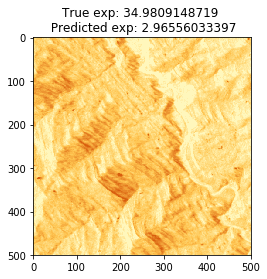

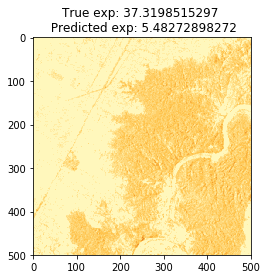

In [49]:
show_image(bad_img1, bad_diff_pred1, bad_diff_true1)
show_image(bad_img2, bad_diff_pred2, bad_diff_true2)

In [9]:
df[df["diff"] < 0.00001]

,Unnamed: 0,latitude,longitude,true,pred,diff
30973,30973,25.254345,81.606339,-0.805076,-0.805072,0.000004
74672,74672,23.284445,84.926552,-0.631951,-0.631946,0.000005


In [50]:
hhid3 = 146256
good_pred_image1 = load_india_tiff(india_dir, hhid3, "s1", "vis", quiet=True)
good_pred_image1 = Image.fromarray(good_pred_image1.transpose((1, 2, 0)))

hhid4 = 323865
good_pred_image2 = load_india_tiff(india_dir, hhid4, "s1", "vis", quiet=True)
good_pred_image2 = Image.fromarray(good_pred_image2.transpose((1, 2, 0)))

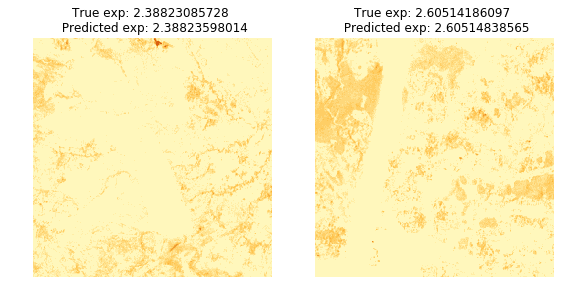

In [51]:
#plt.figure(figsize=(8, 8))
#plt.imshow(min_image_s1)

# visualize a few images from training set
fig = plt.figure(figsize=(8, 8))

ax = plt.subplot(1, 2, 1)
plt.tight_layout()
ax.set_title('True exp: {} \n Predicted exp: {}'.format(z_to_ppp_india(-0.80507621753014), z_to_ppp_india(-0.805072128772735)))
ax.axis('off')

# expects images with shape image.shape = (500, 500, 3)
plt.imshow(image3)
plt.pause(0.01)  # pause a bit so that plots are updated

ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('True exp: {} \n Predicted exp: {}'.format(z_to_ppp_india(-0.631950758048929), z_to_ppp_india(-0.631945550441741)))
ax.axis('off')
plt.imshow(image4)
plt.pause(0.01)  # pause a bit so that plots are updated

plt.show()

In [91]:
valid_csv_file = '../data/india_valid.csv'
valid_df = pd.read_csv(valid_csv_file)

       Unnamed: 0   latitude  longitude      true      pred      diff
5794         5794  31.784498  76.524612  2.996184  3.091553  0.095369
2073         2073  31.681732  76.574040  2.766871  2.731282  0.035589
82073       82073  31.732138  76.507482  2.650187  2.680183  0.029997
30514       30514  31.888640  76.498289  2.591569  2.496284  0.095285
2156         2156  31.640183  76.621637  2.578141  2.616646  0.038505

hhid: 14495
pop: 61
lat: 31.7844981
lon: 76.52461215
hhid: 15353
pop: 17
lat: 31.68173172
lon: 76.57404039
hhid: 15080
pop: 165
lat: 31.73213819
lon: 76.50748165
hhid: 9950
pop: 218
lat: 31.88864028
lon: 76.49828856
hhid: 15852
pop: 654
lat: 31.64018279
lon: 76.62163724


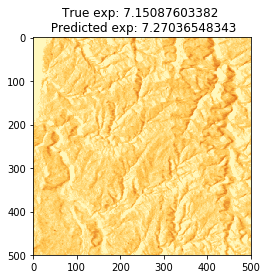

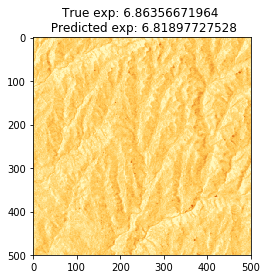

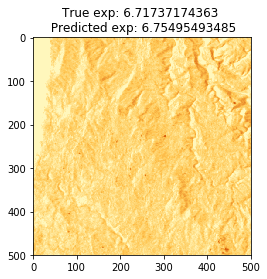

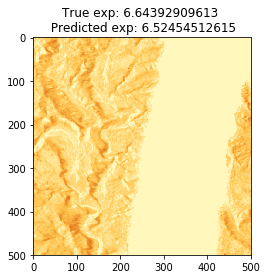

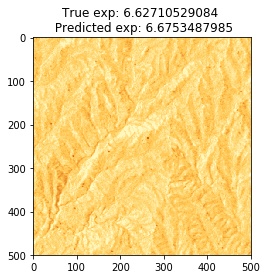

In [116]:
# Here we visualize tiffs for largest true expenditure where prediction was within 0.1 z-score
df_high_exp = df[df["diff"] < 0.1].sort_values(by="true", ascending=False)[0:5]
print(df_high_exp)
print()
for row in range(len(df_high_exp)):
    print("=================")
    lat = df_high_exp.iloc[row]["latitude"]
    lon = df_high_exp.iloc[row]["longitude"]
    true = df_high_exp.iloc[row]["true"]
    pred = df_high_exp.iloc[row]["pred"]
    
    hhid = valid_df[(valid_df["longitude"] == lon) & (valid_df["latitude"] == lat)]["id"].values[0]
    pop = valid_df[(valid_df["longitude"] == lon) & (valid_df["latitude"] == lat)]["secc_pop"].values[0]
    print("hhid:", hhid)
    print("pop:", pop)
    print("lat:", lat)
    print("lon:", lon)
    img = load_india_tiff(india_dir, hhid, "s1", "vis", quiet=True)
    img = Image.fromarray(img.transpose((1, 2, 0)))
    show_image(img, pred, true)
#for i in range(3):
#    show_image(image3, 1, 0)

       Unnamed: 0   latitude  longitude      true      pred      diff
30796       30796  21.809336  74.578696 -1.562522 -1.549130  0.013392
44150       44150  20.234092  73.427091 -1.558336 -1.591845  0.033509
32529       32529  21.771378  74.146655 -1.544131 -1.460705  0.083426
1210         1210  22.520475  74.947873 -1.463325 -1.380804  0.082521

hhid: 417160
pop: 470
lat: 21.80933634
lon: 74.57869632
hhid: 482194
pop: 556
lat: 20.23409159
lon: 73.42709073
hhid: 460198
pop: 464
lat: 21.77137751
lon: 74.14665496
hhid: 414274
pop: 663
lat: 22.52047534
lon: 74.94787269


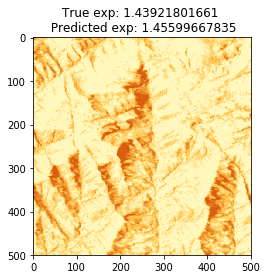

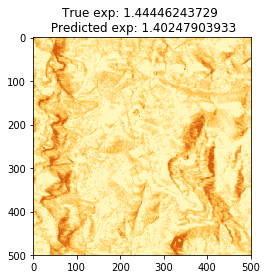

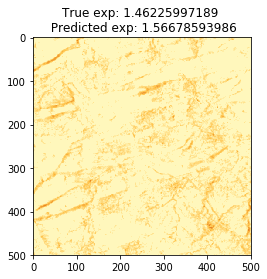

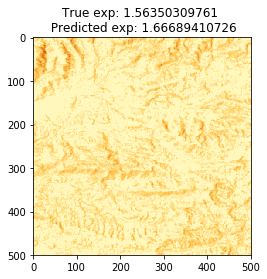

In [164]:
# Here we visualize tiffs for largest population where prediction was within 0.1 z-score
df_low_exp = df[df["diff"] < 0.1].sort_values(by="true", ascending=True)[0:4]
print(df_low_exp)
print()
for row in range(len(df_low_exp)):
    print("=================")
    lat = df_low_exp.iloc[row]["latitude"]
    lon = df_low_exp.iloc[row]["longitude"]
    true = df_low_exp.iloc[row]["true"]
    pred = df_low_exp.iloc[row]["pred"]
    
    hhid = valid_df[(valid_df["longitude"] == lon) & (valid_df["latitude"] == lat)]["id"].values[0]
    pop = valid_df[(valid_df["longitude"] == lon) & (valid_df["latitude"] == lat)]["secc_pop"].values[0]
    print("hhid:", hhid)
    print("pop:", pop)
    print("lat:", lat)
    print("lon:", lon)
    img = load_india_tiff(india_dir, hhid, "s1", "vis", quiet=True)
    img = Image.fromarray(img.transpose((1, 2, 0)))
    show_image(img, pred, true)
#for i in range(3):
#    show_image(image3, 1, 0)

In [153]:
# Here we visualize tiffs for largest population where prediction was within 0.1 z-score
df_rich = df.sort_values(by="true", ascending=True)[0:5]
print(df_rich)
print()
for row in range(len(df_rich)):
    print("=================")
    lat = df_rich.iloc[row]["latitude"]
    lon = df_rich.iloc[row]["longitude"]
    true = df_rich.iloc[row]["true"]
    pred = df_rich.iloc[row]["pred"]
    
    hhid = valid_df[(valid_df["longitude"] == lon) & (valid_df["latitude"] == lat)]["id"].values[0]
    pop = valid_df[(valid_df["longitude"] == lon) & (valid_df["latitude"] == lat)]["secc_pop"].values[0]
    print("hhid:", hhid)
    print("pop:", pop)
    print("lat:", lat)
    print("lon:", lon)
    print()
    #img = load_india_tiff(india_dir, hhid, "s1", "vis", quiet=True)
    #img = Image.fromarray(img.transpose((1, 2, 0)))
    #show_image(img, pred, true)
#for i in range(3):
#    show_image(image3, 1, 0)

       Unnamed: 0   latitude  longitude      true      pred      diff
60891       60891  19.791208  78.352015 -2.704005 -0.267539  2.436466
72748       72748  24.100001  83.113825 -2.676903 -0.385155  2.291748
82196       82196  17.561873  78.769888 -2.626541  0.625510  3.252051
65731       65731  23.201402  76.899054 -2.514757 -0.293211  2.221546
57442       57442  23.579115  74.538420 -2.507304 -0.784813  1.722490

hhid: 475921
pop: 800
lat: 19.7912084
lon: 78.35201537

hhid: 190691
pop: 698
lat: 24.10000116
lon: 83.11382492

hhid: 506733
pop: 1252
lat: 17.56187308
lon: 78.76988803

hhid: 420841
pop: 526
lat: 23.20140183
lon: 76.89905419

hhid: 90689
pop: 448
lat: 23.57911512
lon: 74.53841964



In [160]:
# Here we calculate r2 partitioned by true expenditure
thresholds = [-1.0, -0.5, -0.1, 0, 0.1, 0.5, 1]
for threshold in thresholds:
    print("==============")
    print("threshold:", threshold)
    df_low = df[df["true"] < threshold]
    df_high = df[df["true"] >= threshold]
    r2_low = metrics.r2_score(df_low["true"].values, df_low["pred"].values)
    r2_high = metrics.r2_score(df_high["true"].values, df_high["pred"].values)
    print("r2 low:", r2_low)
    print("r2 high:", r2_high)
    
print()
print()
# Here we calculate r2 without outliers
abs_thresholds = np.linspace(1, 20, 20) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
abs_r2s = []
for abs_thres in abs_thresholds:
    print("=============")
    print("abs value threshold:", abs_thres)
    df_abs = df[df["true"].abs() < abs_thres]
    r2 = metrics.r2_score(df_abs["true"].values, df_abs["pred"].values)
    abs_r2s.append(r2)
    print("r2:", r2)

threshold: -1.0
r2 low: -13.3713500005
r2 high: 0.26875140857
threshold: -0.5
r2 low: -2.89672296155
r2 high: 0.087421417743
threshold: -0.1
r2 low: -0.819402523625
r2 high: -0.173738093844
threshold: 0
r2 low: -0.588363913848
r2 high: -0.244098087307
threshold: 0.1
r2 low: -0.416083031978
r2 high: -0.312138747887
threshold: 0.5
r2 low: 0.0225377858647
r2 high: -0.588971797659
threshold: 1
r2 low: 0.25769250468
r2 high: -0.901891543609


abs value threshold: 1.0
r2: 0.145363656614
abs value threshold: 2.0
r2: 0.41262784613
abs value threshold: 3.0
r2: 0.441716126354
abs value threshold: 4.0
r2: 0.434510525756
abs value threshold: 5.0
r2: 0.422001040895
abs value threshold: 6.0
r2: 0.409689850348
abs value threshold: 7.0
r2: 0.398578042356
abs value threshold: 8.0
r2: 0.387485174327
abs value threshold: 9.0
r2: 0.38042804209
abs value threshold: 10.0
r2: 0.376127109077
abs value threshold: 11.0
r2: 0.372407168822
abs value threshold: 12.0
r2: 0.366826978738
abs value threshold: 13.0
r2:

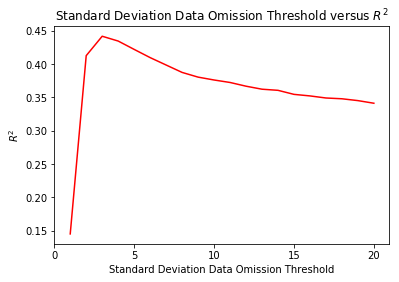

In [162]:
plt.plot(abs_thresholds, abs_r2s, '-r')
#plt.axis([0, 20, 0, 0.5])
plt.xticks(np.arange(0, 21, 5))
plt.xlabel('Standard Deviation Data Omission Threshold')
plt.ylabel('$R^2$')
plt.title('Standard Deviation Data Omission Threshold versus $R^2$')
plt.show()